In [1]:
import filecmp
import os
import shutil
import re
import json
import pandas as pd
import time
import logging
import time
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
import zipfile

In [2]:
cid = '7fffb74083874b72a336d4e4b35ca2db'
secret = '66f0b32349a445a5a7173ebeb3dd741a'

In [3]:
path = 'Data/my_spotify_data/Spotify Account Data'
filenames = os.listdir(path)
os.makedirs('Data', exist_ok=True)

### DATA CLEANING

In [4]:
# unzip file
def unzip_file(zip_file, extract_dir):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

unzip_file('Data/my_spotify_data.zip', 'Data')

In [5]:
combined_data = []

for filename in filenames:
    if filename.startswith("StreamingHistory_music") and filename.endswith(".json"):
        path = os.path.join('Data/my_spotify_data/Spotify Account Data', filename)
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            combined_data.extend(data)

df = pd.DataFrame(combined_data)

correct invalid times

In [6]:
def correctInvalidTimes(df, time_col):
    def correct_time(row):
        try:
            pd.to_datetime(row, format="%Y-%m-%d %H:%M")
            return row
        except ValueError:
            parts = row.split(' ')
            date = parts[0]
            time = parts[1]
            hours, minutes = time.split(':')
            hours = int(hours)
            minutes = int(minutes)

            # Correct invalid minutes
            if minutes >= 60:
                extra_hours = minutes // 60
                minutes = minutes % 60
                hours += extra_hours
            
            # Correct invalid hours
            if hours >= 24:
                hours = hours % 24

            corrected_time = f"{date} {hours:02}:{minutes:02}"
            return corrected_time

    df[time_col] = df[time_col].apply(correct_time)
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce', format="%Y-%m-%d %H:%M")
    return df

def filterShortSongs(df, duration_col='msPlayed', min_duration=30000):
    return df[df[duration_col] >= min_duration]

In [7]:
df['endTime'] = pd.to_datetime(df['endTime'])

latest_date = df['endTime'].max()

two_months_before_latest = latest_date - pd.DateOffset(months=2)

df = df[df['endTime'] >= two_months_before_latest]

In [8]:
df = correctInvalidTimes(df, "endTime")
df = filterShortSongs(df)

In [9]:
df.to_csv('Data/filtered_streaming_history.csv')

### METADATA EXTRACTION

In [10]:
uniqueSongs = df.drop(columns=['endTime', 'msPlayed']).drop_duplicates()

In [11]:
len(uniqueSongs)

969

In [12]:
def append_to_csv(df, filepath='Data/newSongsWithURIs.csv'):
    df.to_csv(filepath, mode='a', header=not os.path.exists(filepath), index=False)

def get_uris_and_append(df):
    spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=cid, client_secret=secret), requests_timeout=10, retries=10)

     # Replace NaN with empty strings in the relevant columns
    df['trackName'] = df['trackName'].fillna('').astype(str)
    df['artistName'] = df['artistName'].fillna('').astype(str)

    for i in tqdm(range(df.shape[0])):
        item = df.iloc[i:i+1]  # Keep as dataframe
        track = item["trackName"].values[0].strip()
        artist = item["artistName"].values[0].strip()

        try:
            searchResults = spotify.search(q=f"track:{track} artist:{artist}", type="track")
            if searchResults['tracks']['items']:
                track_info = searchResults['tracks']['items'][0]
                track_link = track_info['external_urls']['spotify']
                track_URI = track_link.split("/")[-1].split("?")[0]
                item["uri_link"] = track_URI
            else:
                item["uri_link"] = "None"
        except Exception as e:
            print(f"Error for track {track} by {artist}: {e}")
            item["uri_link"] = "None"
        append_to_csv(item)
        time.sleep(0.1)

In [13]:
# get_uris_and_append(uniqueSongs)

In [14]:
logging.basicConfig(filename='Data/audio_features.log', level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

def append_to_csv(df, filepath='final_audio_features.csv'):
    """Appends DataFrame to CSV."""
    try:
        df.to_csv(filepath, mode='a', header=not os.path.exists(filepath), index=False)
        logging.info(f"Successfully appended {len(df)} records to {filepath}")
    except Exception as e:
        logging.error(f"Error while writing to CSV: {e}")

def divide_chunks(l, n):
    """Divides list into chunks of size n."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def get_audio_features(df, filepath='Data/final_audio_features.csv'):
    """Fetches audio features for tracks and appends to CSV after each chunk."""
    spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=cid, client_secret=secret),
                              requests_timeout=10, retries=10)

    tracks_uri_list = df["uri_link"].tolist()
    artist = df["artistName"].tolist()
    track = df["trackName"].tolist()
    tracks_uri_chunks = list(divide_chunks(tracks_uri_list, 50)) 

    for chunk_index, chunk in enumerate(tqdm(tracks_uri_chunks)):
        audio_features = []
        try:
            features = spotify.audio_features(tracks=chunk)
            if features:
                for feature in features:
                    if feature is None:  
                        logging.warning(f"Audio feature unavailable for chunk {chunk_index} - skipping track.")
                        audio_features.append(None)  
                    else:
                        audio_features.append(feature)
            else:
                logging.warning(f"Empty response from Spotify API for chunk {chunk_index}.")
                audio_features = [None] * len(chunk)  
        except Exception as e:
            logging.error(f"Error fetching audio features for chunk {chunk_index}: {e}")
            audio_features = [None] * len(chunk) 
        time.sleep(0.2)  
        if len(audio_features) < len(chunk):
            audio_features.extend([None] * (len(chunk) - len(audio_features))) 

        chunk_result = pd.DataFrame()
        chunk_result["trackName"] = track[chunk_index * 50:(chunk_index + 1) * 50]
        chunk_result["artistName"] = artist[chunk_index * 50:(chunk_index + 1) * 50]
        chunk_result["spotify_uri"] = chunk
        chunk_result["audio_features"] = audio_features

        append_to_csv(chunk_result, filepath=filepath)

In [15]:
uniqueSongs = pd.read_csv('Data/newSongsWithURIs.csv')

In [16]:
# get_audio_features(uniqueSongs)

In [17]:
import ast

def expand_audio_features(df):
    songs_dict = df.to_dict('records')
    
    for song in songs_dict:
        song['audio_features'] = ast.literal_eval(song['audio_features'])
        
        for feature in song['audio_features']:
            song[feature] = song['audio_features'][feature]
            
    display(songs_dict)
    
    final_songs_df = pd.DataFrame(songs_dict)
    
    final_songs_df = final_songs_df.drop(columns=['audio_features', 'id', 'uri', 'track_href', 'analysis_url', 'type'])
    
    return final_songs_df

In [18]:
songs_df = pd.read_csv('Data/final_audio_features.csv')

display(songs_df)
songs_df = songs_df.dropna()

songs_df = expand_audio_features(songs_df)


def mapUserToSongs(df, songs_df):
    merged_df = pd.merge(df, songs_df, on=['trackName', 'artistName'], how='inner')
    merged_df.to_csv('Data/user_listening_history.csv', index=False)

,trackName,artistName,spotify_uri,audio_features
0,I Hope to Be Around,Men I Trust,3xnM0WCRJKk4Iz49rkG5OC,"{'danceability': 0.821, 'energy': 0.384, 'key'..."
1,Only Ones Who Know,Arctic Monkeys,7ABWRukVQcXrIrDKDx5Gek,"{'danceability': 0.257, 'energy': 0.409, 'key'..."
2,Pumped Up Kicks,Foster The People,7w87IxuO7BDcJ3YUqCyMTT,"{'danceability': 0.733, 'energy': 0.71, 'key':..."
3,Another Love,Tom Odell,3JvKfv6T31zO0ini8iNItO,"{'danceability': 0.445, 'energy': 0.537, 'key'..."
4,505,Arctic Monkeys,58ge6dfP91o9oXMzq3XkIS,"{'danceability': 0.52, 'energy': 0.852, 'key':..."
...,...,...,...,...
964,Loki Green Theme,Natalie Holt,5T7DUEeAj0hkMLTzIlDCRz,"{'danceability': 0.458, 'energy': 0.475, 'key'..."
965,Story Of Wick,Tyler Bates,2IcdRlgkwZuVC6AQdawHJ2,"{'danceability': 0.55, 'energy': 0.46, 'key': ..."
966,Fallout,Lorne Balfe,0llzwIl1LZHvOW2GIKJ3jQ,"{'danceability': 0.434, 'energy': 0.404, 'key'..."
967,Autobots,Steve Jablonsky,1hQMzVXdoDZXcO16GOhWc5,"{'danceability': 0.392, 'energy': 0.492, 'key'..."


[{'trackName': 'I Hope to Be Around',
  'artistName': 'Men I Trust',
  'spotify_uri': '3xnM0WCRJKk4Iz49rkG5OC',
  'audio_features': {'danceability': 0.821,
   'energy': 0.384,
   'key': 11,
   'loudness': -9.353,
   'mode': 1,
   'speechiness': 0.0388,
   'acousticness': 0.78,
   'instrumentalness': 0.00138,
   'liveness': 0.11,
   'valence': 0.79,
   'tempo': 87.978,
   'type': 'audio_features',
   'id': '3xnM0WCRJKk4Iz49rkG5OC',
   'uri': 'spotify:track:3xnM0WCRJKk4Iz49rkG5OC',
   'track_href': 'https://api.spotify.com/v1/tracks/3xnM0WCRJKk4Iz49rkG5OC',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3xnM0WCRJKk4Iz49rkG5OC',
   'duration_ms': 205554,
   'time_signature': 4},
  'danceability': 0.821,
  'energy': 0.384,
  'key': 11,
  'loudness': -9.353,
  'mode': 1,
  'speechiness': 0.0388,
  'acousticness': 0.78,
  'instrumentalness': 0.00138,
  'liveness': 0.11,
  'valence': 0.79,
  'tempo': 87.978,
  'type': 'audio_features',
  'id': '3xnM0WCRJKk4Iz49rkG5OC',
  'uri':

In [19]:
mapUserToSongs(df, songs_df)

In [20]:
user_df = pd.read_csv('Data/user_listening_history.csv')
user_df 

,endTime,artistName,trackName,msPlayed,spotify_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2024-03-01 22:26:00,Men I Trust,I Hope to Be Around,205554,3xnM0WCRJKk4Iz49rkG5OC,0.821,0.384,11,-9.353,1,0.0388,0.780,0.00138,0.1100,0.7900,87.978,205554,4
1,2024-03-03 21:27:00,Men I Trust,I Hope to Be Around,166914,3xnM0WCRJKk4Iz49rkG5OC,0.821,0.384,11,-9.353,1,0.0388,0.780,0.00138,0.1100,0.7900,87.978,205554,4
2,2024-03-10 10:10:00,Men I Trust,I Hope to Be Around,33552,3xnM0WCRJKk4Iz49rkG5OC,0.821,0.384,11,-9.353,1,0.0388,0.780,0.00138,0.1100,0.7900,87.978,205554,4
3,2024-03-28 14:36:00,Men I Trust,I Hope to Be Around,205554,3xnM0WCRJKk4Iz49rkG5OC,0.821,0.384,11,-9.353,1,0.0388,0.780,0.00138,0.1100,0.7900,87.978,205554,4
4,2024-03-01 22:27:00,Arctic Monkeys,Only Ones Who Know,103253,7ABWRukVQcXrIrDKDx5Gek,0.257,0.409,7,-10.828,0,0.0363,0.899,0.00293,0.1090,0.0794,145.759,181480,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,2024-05-01 18:58:00,Natalie Holt,Loki Green Theme,53844,5T7DUEeAj0hkMLTzIlDCRz,0.458,0.475,5,-12.581,1,0.0320,0.760,0.83600,0.1250,0.1320,126.055,144762,4
2871,2024-05-01 19:01:00,Tyler Bates,Story Of Wick,184920,2IcdRlgkwZuVC6AQdawHJ2,0.550,0.460,7,-12.097,1,0.0338,0.300,0.85200,0.0929,0.2240,175.674,184920,4
2872,2024-05-01 19:02:00,Lorne Balfe,Fallout,90080,0llzwIl1LZHvOW2GIKJ3jQ,0.434,0.404,0,-13.207,1,0.0458,0.341,0.89900,0.0734,0.1360,168.919,90080,5
2873,2024-05-01 19:05:00,Steve Jablonsky,Autobots,153026,1hQMzVXdoDZXcO16GOhWc5,0.392,0.492,7,-14.757,0,0.0570,0.572,0.95900,0.1090,0.1750,80.016,153027,3


### TEMPORAL TRENDS

In [21]:
feature_columns = ['valence', 'energy', 'danceability', 'loudness']

In [22]:
import matplotlib.pyplot as plt

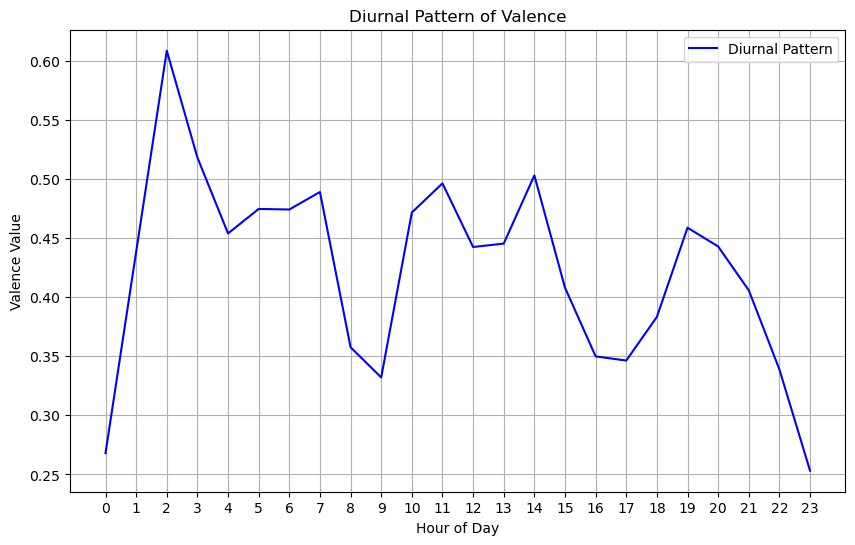

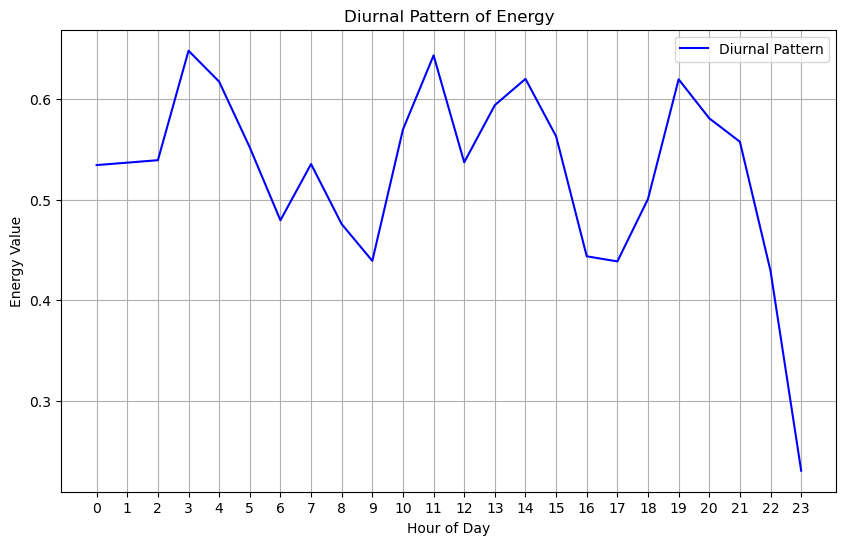

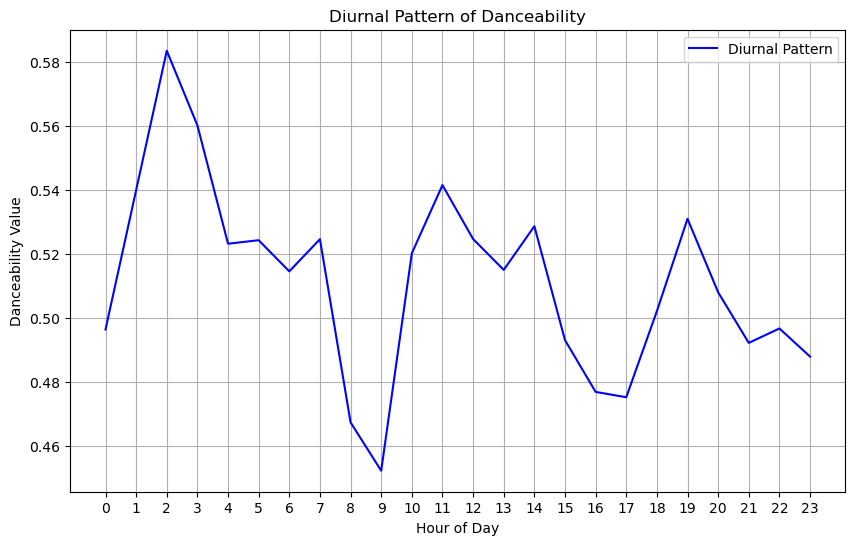

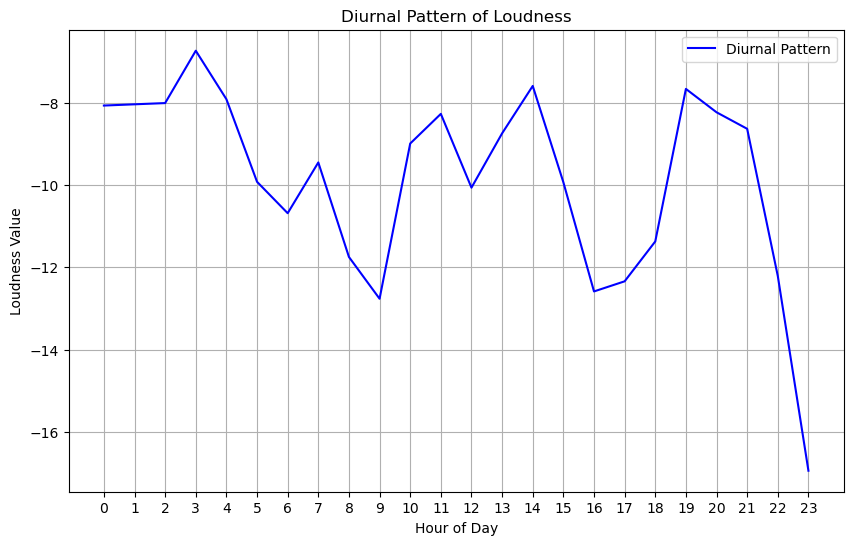

In [23]:
def extract_hour(df, time_column):
    """Extract the hour from the datetime column."""
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df['hour_of_day'] = df[time_column].dt.hour
    return df

def compute_diurnal_patterns(df, feature_columns, time_column):
    """Compute the mean diurnal pattern of audio features."""
    df = extract_hour(df, time_column)
    
    df = df.dropna(subset=['hour_of_day'] + feature_columns)

    diurnal_patterns = df.groupby('hour_of_day')[feature_columns].mean()
    
    diurnal_patterns.to_csv('Data/diurnal_patterns.csv', index=False)
    
    return diurnal_patterns

def plot_diurnal_patterns(df, feature_columns, time_column):
    """Plot diurnal patterns for features in the given DataFrame."""
    
    diurnal_patterns = compute_diurnal_patterns(df, feature_columns, time_column)
    
    for feature in feature_columns:
        plt.figure(figsize=(10, 6))
        
        plt.plot(diurnal_patterns.index, diurnal_patterns[feature], label='Diurnal Pattern', color='blue')
        
        plt.title(f'Diurnal Pattern of {feature.capitalize()}')
        plt.xlabel('Hour of Day')
        plt.ylabel(f'{feature.capitalize()} Value')
        plt.xticks(range(0, 24))
        plt.legend()
        plt.grid(True)
        plt.show()

plot_diurnal_patterns(user_df, feature_columns, 'endTime')

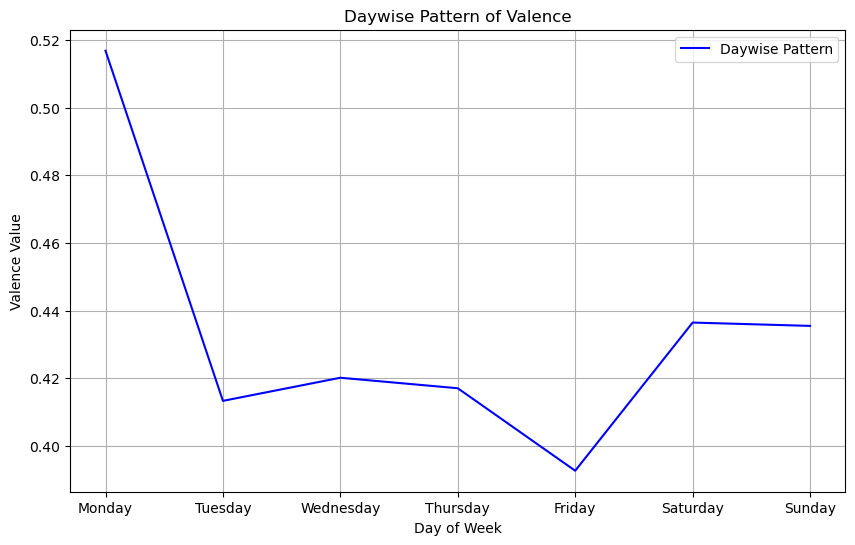

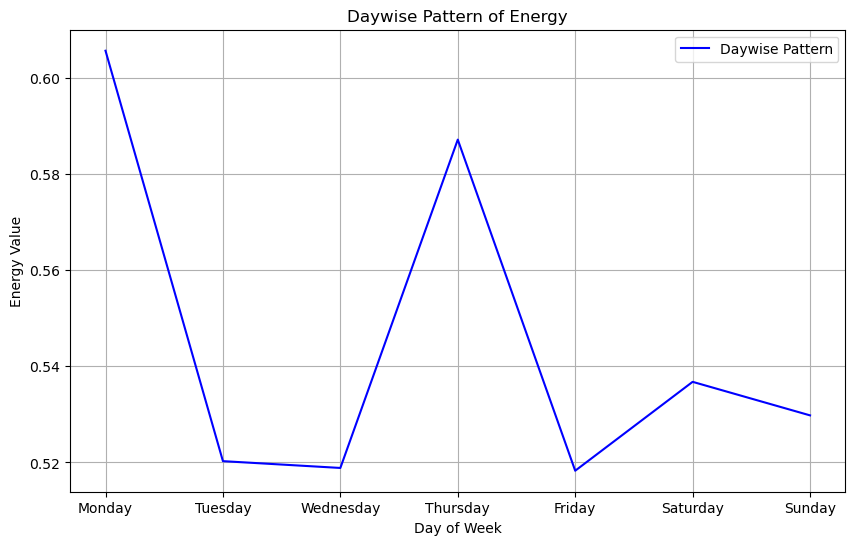

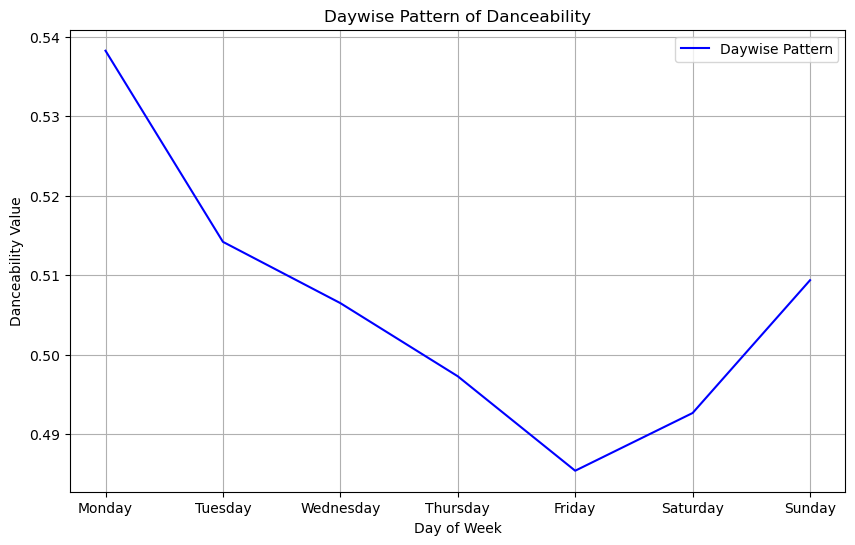

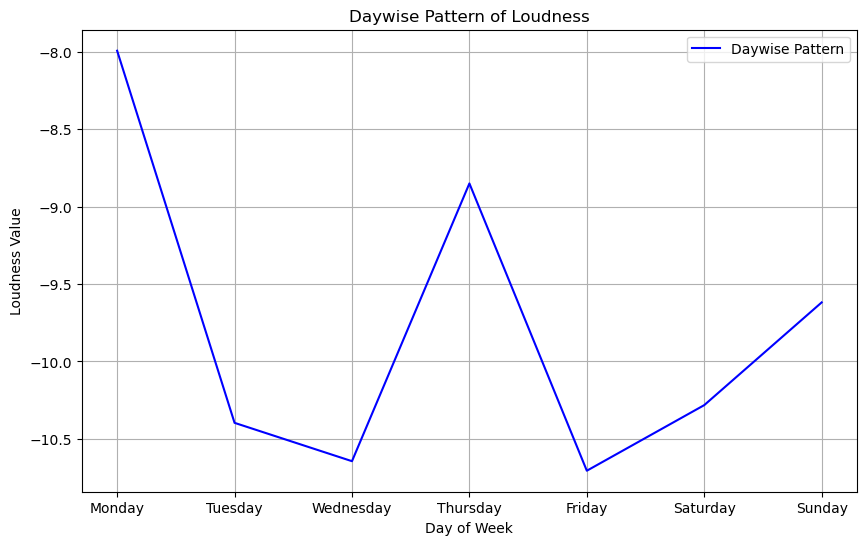

In [24]:
def extract_day_of_week(df, time_column):
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df['day_of_week'] = df[time_column].dt.dayofweek
    return df

def compute_daywise_patterns(df, feature_columns, time_column):
    df = extract_day_of_week(df, time_column)
    df = df.dropna(subset=['day_of_week'] + feature_columns)
    daywise_patterns = df.groupby('day_of_week')[feature_columns].mean()
    
    daywise_patterns.to_csv('Data/daywise_week_patterns.csv', index=False)
    
    return daywise_patterns

def plot_daywise_patterns(df, feature_columns, time_column):
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daywise_patterns = compute_daywise_patterns(df, feature_columns, time_column)
    
    for feature in feature_columns:
        plt.figure(figsize=(10, 6))
        plt.plot(daywise_patterns.index, daywise_patterns[feature], label='Daywise Pattern', color='blue')
        plt.title(f'Daywise Pattern of {feature.capitalize()}')
        plt.xlabel('Day of Week')
        plt.ylabel(f'{feature.capitalize()} Value')
        plt.xticks(ticks=range(7), labels=day_labels)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_daywise_patterns(user_df, feature_columns, 'endTime')

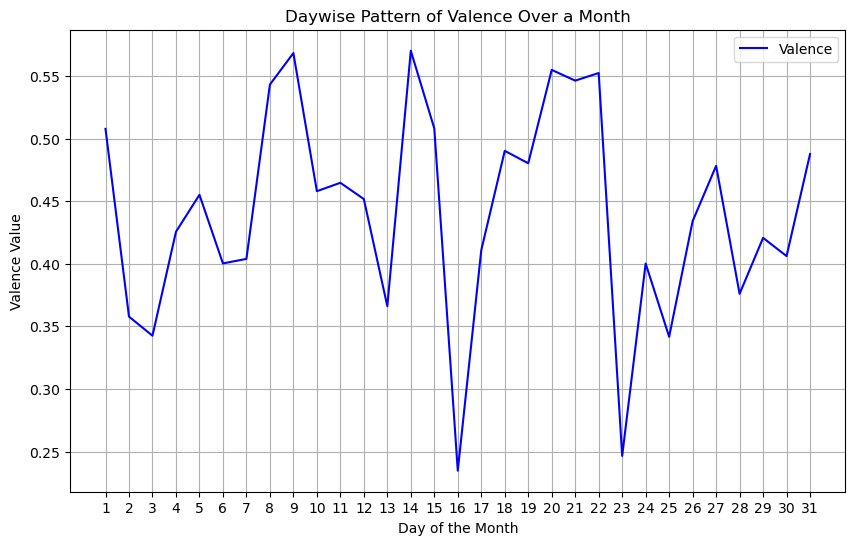

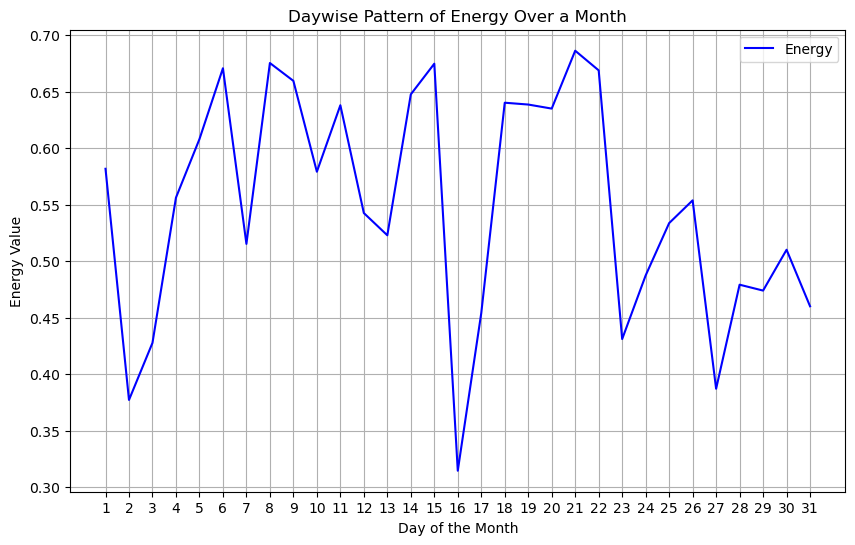

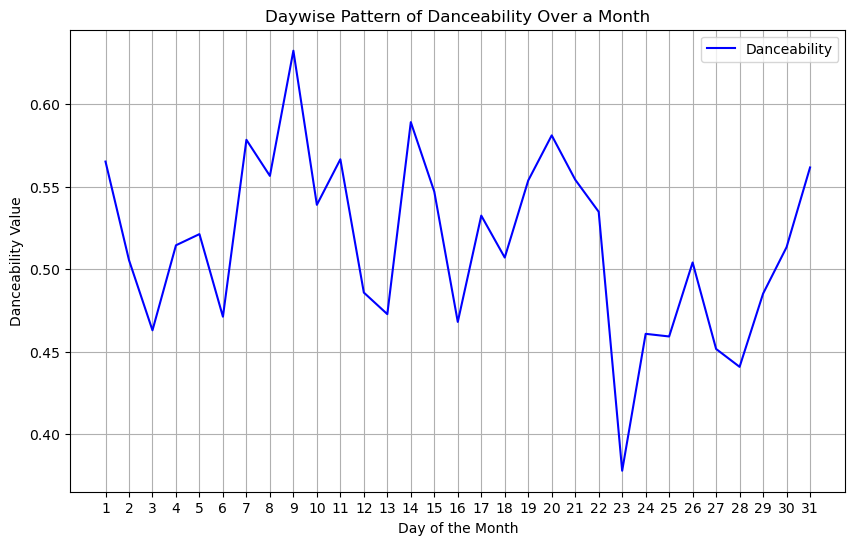

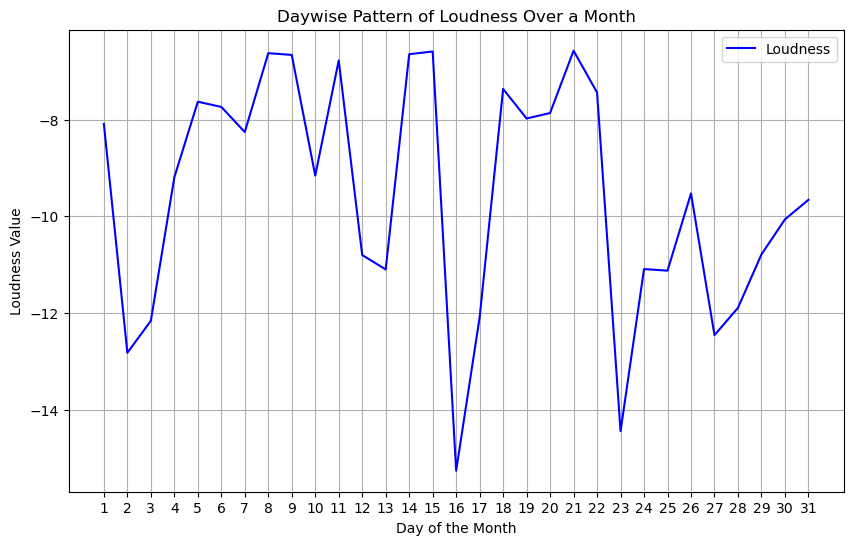

In [25]:
def extract_day_of_month(df, time_column):
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df['day_of_month'] = df[time_column].dt.day
    return df

def compute_daywise_month_patterns(df, feature_columns, time_column):
    df = extract_day_of_month(df, time_column)
    df = df.dropna(subset=['day_of_month'] + feature_columns)
    daywise_month_patterns = df.groupby('day_of_month')[feature_columns].mean()
    
    daywise_month_patterns.to_csv('Data/daywise_month_patterns.csv', index=False)
        
    return daywise_month_patterns

def plot_daywise_month_patterns(df, feature_columns, time_column):
    daywise_month_patterns = compute_daywise_month_patterns(df, feature_columns, time_column)
    
    for feature in feature_columns:
        plt.figure(figsize=(10, 6))
        plt.plot(daywise_month_patterns.index, daywise_month_patterns[feature], label=feature.capitalize(), color='blue')
        
        plt.title(f'Daywise Pattern of {feature.capitalize()} Over a Month')
        plt.xlabel('Day of the Month')
        plt.ylabel(f'{feature.capitalize()} Value')
        plt.xticks(range(1, 32))
        plt.legend()
        plt.grid(True)
        plt.show()

plot_daywise_month_patterns(user_df, feature_columns, 'endTime')